In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

pd.set_option("display.max_columns", 100)

df = pd.read_csv("../data/multidimensional.csv")
df.head()

,unit_id,tries_amount,questionnaire_amount,dimensions_amount,document_amount,current_try,q_0_age_question,q_0_age_answer,q_0_age_value,q_0_school_question,q_0_school_answer,q_0_school_value,q_0_taxes_question,q_0_taxes_answer,q_0_taxes_value,q_0_political_views_question,q_0_political_views_answer,q_0_political_views_value,q_0_consideration_question,q_0_consideration_answer,q_0_consideration_value,q_0_southern_border_question,q_0_southern_border_answer,q_0_southern_border_value,q_0_environment_question,q_0_environment_answer,q_0_environment_value,q_0_time_elapsed,q_0_accesses,q_1_farmers_question,q_1_farmers_answer,q_1_farmers_value,q_1_time_elapsed,q_1_accesses,q_2_marks_question,q_2_marks_answer,q_2_marks_value,q_2_time_elapsed,q_2_accesses,q_3_athletics_question,q_3_athletics_answer,q_3_athletics_value,q_3_time_elapsed,q_3_accesses,doc_index,doc_name,doc_statement,doc_claimant,doc_date,doc_originatedFrom,doc_ground_truth_value,doc_ground_truth_abc_label,doc_ground_truth_abc_verdict,doc_ground_truth_politifact_label,doc_source,doc_overall-truthfulness_value,doc_overall-truthfulness_label,doc_overall-truthfulness_justification,doc_overall-truthfulness_url,doc_confidence_value,doc_confidence_label,doc_confidence_justification,doc_confidence_url,doc_correctness_value,doc_correctness_label,doc_correctness_justification,doc_correctness_url,doc_neutrality_value,doc_neutrality_label,doc_neutrality_justification,doc_neutrality_url,doc_comprehensibility_value,doc_comprehensibility_label,doc_comprehensibility_justification,doc_comprehensibility_url,doc_precision_value,doc_precision_label,doc_precision_justification,doc_precision_url,doc_completeness_value,doc_completeness_label,doc_completeness_justification,doc_completeness_url,doc_speaker's-trustworthiness_value,doc_speaker's-trustworthiness_label,doc_speaker's-trustworthiness_justification,doc_speaker's-trustworthiness_url,doc_informativeness_value,doc_informativeness_label,doc_informativeness_justification,doc_informativeness_url,doc_accesses,doc_time_elapsed
0,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,0.0,Liberal_In_Between_doc1,What the states do is a matter for the states ...,Tony Abbott,2013.0,NaN,3.0,in-between,lawyer's picnic,NaN,abc,1.0,agree,NaN,https://www.thenewamerican.com/usnews/constitu...,-1.0,disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,-1.0,disagree,NaN,NaN,0.0,neither-agree-nor-disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,175.61
1,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,1.0,Labor_Negative_doc3,Mr Abbott seems to be suffering from just a li...,Kevin Rudd,2013.0,NaN,4.0,negative,wrong,NaN,abc,2.0,completely-agree,NaN,https://

In [12]:
# compute CRT scores
q1_value = df["q_1_farmers_value"]
q1_score = (q1_value == 3.0).astype("int")
df["q_1_farmers_score"] = q1_score

q2_value = df["q_2_marks_value"]
q2_score = (q2_value == 9.0).astype("int")
df["q_2_marks_score"] = q2_score

q3_value = df["q_3_athletics_value"]
q3_score = (q3_value == 16.0).astype("int")
df["q_3_athletics_score"] = q3_score

df.to_csv("../data/multidimensional_with_crt.csv", index=False)

In [27]:
worker_data = df[[
    "unit_id",
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
    "q_0_age_answer", 
    "q_0_school_answer", 
    "q_0_taxes_answer", 
    "q_0_political_views_answer", 
    "q_0_consideration_answer", 
    "q_0_southern_border_answer", 
    "q_0_environment_answer", 
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]

worker_data = worker_data.drop_duplicates()
worker_data["doc_assessment_mse"] = 0.0
worker_data = worker_data.set_index("unit_id")
worker_data_num = worker_data.select_dtypes(include=np.number)
worker_data_num = (worker_data_num - worker_data_num.min()) / (worker_data_num.max() - worker_data_num.min())
worker_data[worker_data_num.columns] = worker_data_num
worker_data.sample(5)

,q_0_age_value,q_0_school_value,q_0_taxes_value,q_0_political_views_value,q_0_consideration_value,q_0_southern_border_value,q_0_environment_value,q_0_age_answer,q_0_school_answer,q_0_taxes_answer,q_0_political_views_answer,q_0_consideration_answer,q_0_southern_border_answer,q_0_environment_answer,q_1_farmers_score,q_2_marks_score,q_3_athletics_score,doc_assessment_mse
unit_id,,,,,,,,,,,,,,,,,,
unit_24,0.333333,0.50,1.000,0.25,0.000000,0.0,0.0,26-35,Four year college degree/bachelor’s degree,"150,000 or more",Conservative,Republican,Agree,Agree,1.0,1.0,0.0,NaN
unit_95,0.333333,0.00,0.500,0.50,0.666667,0.5,0.0,26-35,High school graduate or GED (includes technica...,"40,000 to less than 50,000",Moderate,Independent,Disagree,Agree,0.0,0.0,0.0,NaN
unit_87,0.666667,0.25,0.750,0.00,0.000000,0.0,1.0,36-50,"Some college (some community college, associat...","75,000 to less than 100,000",Very conservative,Republican,Agree,No opinion either way,0.0,0.0,0.0,NaN
unit_127,0.666667,0.25,0.500,0.25,0.000000,0.0,0.5,36-50,"Some college (some community college, associat...","40,000 to less than 50,000",Conservative,Republican,Agree,Disagree,1.0,0.0,0.0,NaN
unit_158,0.333333,0.50,0.125,0.25,0.333333,0.0,0.0,26-35,Four year college degree/bachelor’s degree,"10,000 to less than 20,000",Conservative,Democrat,Agree,Agree,0.0,0.0,0.0,NaN


#### Hypothesis
Reliable workers intend to show a lower mean square error on their assessment of the statements.

#### To test
If there are any correlation between the work profile data and the mse score of their assessment.

In [28]:
# compute variance between ground truth and assessments
worker_groups = df.groupby(by="unit_id")
for worker, group in worker_groups:
    truth = group["doc_ground_truth_value"] - 2
    assessment = group["doc_overall-truthfulness_value"]
    mse = mean_squared_error(truth, assessment)
    worker_data.loc[worker, "doc_assessment_mse"] = mse
worker_data.describe()

,q_0_age_value,q_0_school_value,q_0_taxes_value,q_0_political_views_value,q_0_consideration_value,q_0_southern_border_value,q_0_environment_value,q_1_farmers_score,q_2_marks_score,q_3_athletics_score,doc_assessment_mse
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.391667,0.521250,0.536875,0.561250,0.330000,0.33250,0.105000,0.500000,0.295000,0.075000,1.305909
std,0.280459,0.275436,0.247410,0.312529,0.258825,0.29772,0.268019,0.501255,0.457187,0.264052,1.053145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.437500,0.375000,0.250000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.545455
50%,0.333333,0.500000,0.500000,0.500000,0.333333,0.50000,0.000000,0.500000,0.000000,0.000000,1.000000
75%,0.666667,0.500000,0.750000,0.750000,0.666667,0.50000,0.000000,1.000000,1.000000,0.000000,1.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,5.545455


With such matrix, we are looking forward to finding groups of features. For instance, in the corr matrix below, "q_0_age_value", "q_0_school_value" and "q_0_taxes_value" can be considered as one group (negative), while "q_0_political_views_value", "q_0_consideration_value" and "q_0_southern_border_value" can be considered as another group (positive)

<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_age_answer'>

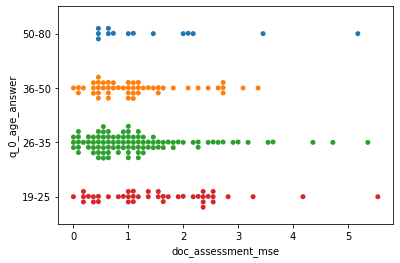

In [63]:
sns.swarmplot(y="q_0_age_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_age_value", ascending=False))

<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_age_answer'>

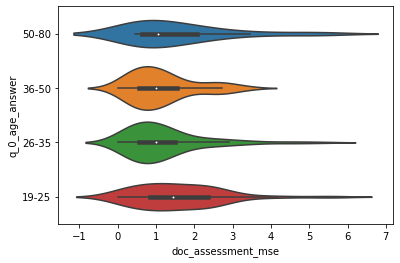

In [62]:
sns.violinplot(y="q_0_age_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_age_value", ascending=False))

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_age_answer'>

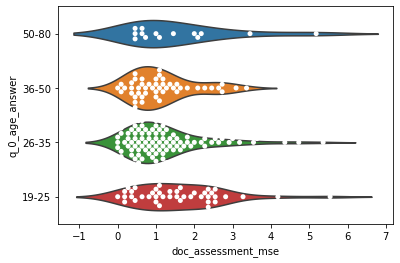

In [58]:
sns.violinplot(y="q_0_age_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_age_value", ascending=False), inner=None)
sns.swarmplot(y="q_0_age_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_age_value", ascending=False), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_school_answer'>

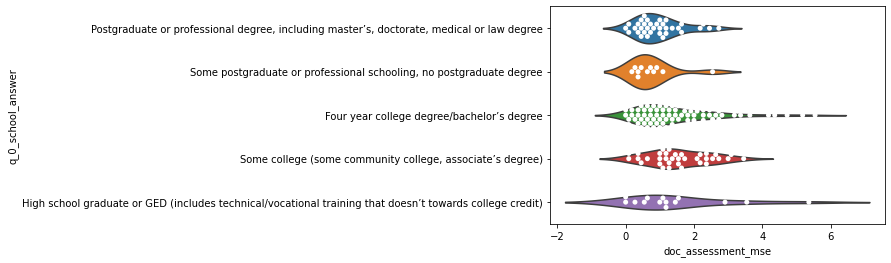

In [61]:
sns.violinplot(y="q_0_school_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_school_value", ascending=False), inner=None)
sns.swarmplot(y="q_0_school_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_school_value", ascending=False), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_taxes_answer'>

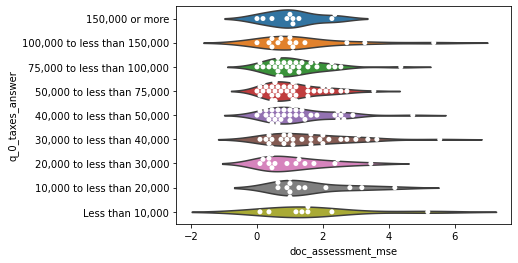

In [64]:
sns.violinplot(y="q_0_taxes_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_taxes_value", ascending=False), inner=None)
sns.swarmplot(y="q_0_taxes_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_taxes_value", ascending=False), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_political_views_answer'>

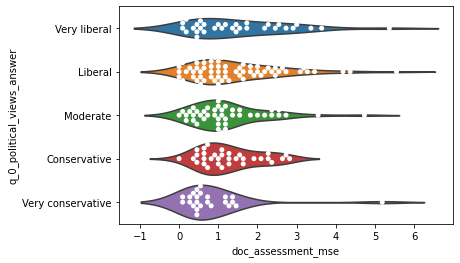

In [65]:
sns.violinplot(y="q_0_political_views_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_political_views_value", ascending=False), inner=None)
sns.swarmplot(y="q_0_political_views_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_political_views_value", ascending=False), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_consideration_answer'>

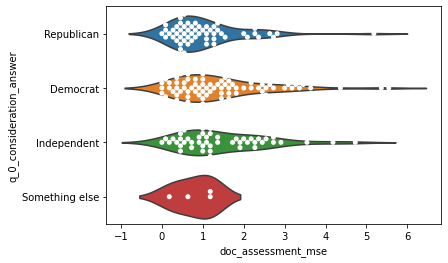

In [67]:
sns.violinplot(y="q_0_consideration_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_consideration_value"), inner=None)
sns.swarmplot(y="q_0_consideration_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_consideration_value"), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_southern_border_answer'>

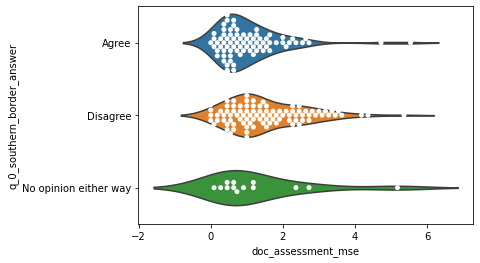

In [68]:
sns.violinplot(y="q_0_southern_border_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_southern_border_value"), inner=None)
sns.swarmplot(y="q_0_southern_border_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_southern_border_value"), color="white")

/home/jiqi/miniconda3/envs/eda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='doc_assessment_mse', ylabel='q_0_environment_answer'>

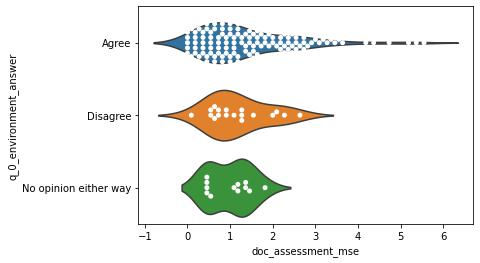

In [69]:
sns.violinplot(y="q_0_environment_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_environment_value"), inner=None)
sns.swarmplot(y="q_0_environment_answer", x="doc_assessment_mse", data=worker_data.sort_values(by="q_0_environment_value"), color="white")

<AxesSubplot:xlabel='q_1_farmers_score', ylabel='doc_assessment_mse'>

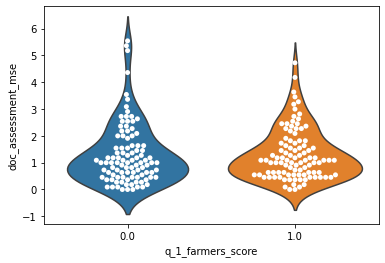

In [70]:
sns.violinplot(x="q_1_farmers_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_1_farmers_score"), inner=None)
sns.swarmplot(x="q_1_farmers_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_1_farmers_score"), color="white")

<AxesSubplot:xlabel='q_2_marks_score', ylabel='doc_assessment_mse'>

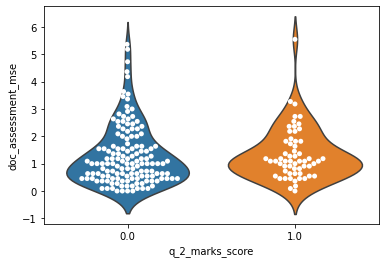

In [72]:
sns.violinplot(x="q_2_marks_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_2_marks_score"), inner=None)
sns.swarmplot(x="q_2_marks_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_2_marks_score"), color="white")

<AxesSubplot:xlabel='q_3_athletics_score', ylabel='doc_assessment_mse'>

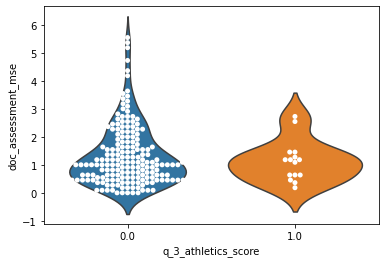

In [73]:
sns.violinplot(x="q_3_athletics_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_3_athletics_score"), inner=None)
sns.swarmplot(x="q_3_athletics_score", y="doc_assessment_mse", data=worker_data.sort_values(by="q_3_athletics_score"), color="white")

#### Categorical independent variables encoding
[Here](https://stats.oarc.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/) is a link of different encoding methods. In our case, simple encoding is applied, but this could be improved, since for some of the columns (e.g. political view and consideration), the values doesn't have to be ordinal.

<AxesSubplot:>

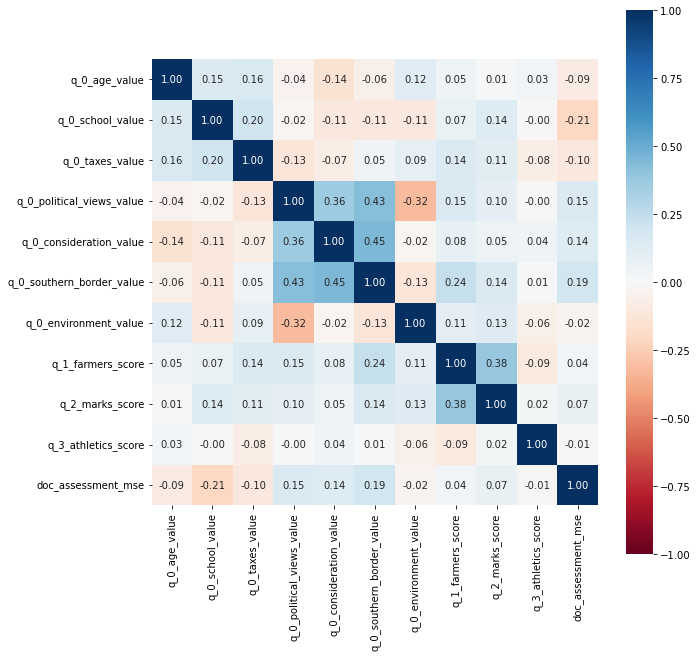

In [75]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=worker_data.corr(method="spearman"),  # pearson and kendall also give similar results
    cmap="RdBu", 
    vmin=-1, 
    vmax=1, 
    square=True, 
    annot=True, 
    fmt=".2f"
)

In [6]:
# machine learning tasks setup
X = worker_data[[
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
y = worker_data["doc_assessment_mse"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_basic = X_train[[
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
]]
X_train_policical = X_train[[
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
]]
X_train_crt = X_train[[
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
kfold = KFold(n_splits=10)

In [7]:
# model selection
model_lr = LinearRegression()
model_rfr = RandomForestRegressor()
model_dtr = DecisionTreeRegressor()
model_gpr = GaussianProcessRegressor()
model_svr = SVR()

def model_comparision(X, y):
    results_lr = cross_val_score(model_lr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_rfr = cross_val_score(model_rfr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_dtr = cross_val_score(model_dtr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_gpr = cross_val_score(model_gpr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_svr = cross_val_score(model_svr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')


    print("RMSE lr: %.3f (+/-%.3f)" % (-results_lr.mean(), results_lr.std()))
    print("RMSE rfr: %.3f (+/-%.3f)" % (-results_rfr.mean(), results_rfr.std()))
    print("RMSE dtr: %.3f (+/-%.3f)" % (-results_dtr.mean(), results_dtr.std()))
    print("RMSE gpr: %.3f (+/-%.3f)" % (-results_gpr.mean(), results_gpr.std()))
    print("RMSE svr: %.3f (+/-%.3f)" % (-results_svr.mean(), results_svr.std()))
    print()

print("X_all:")
model_comparision(X=X_train, y=y_train)
print("X_basic:")
model_comparision(X=X_train_basic, y=y_train)
print("X_policical:")
model_comparision(X=X_train_policical, y=y_train)
print("X_crt:")
model_comparision(X=X_train_crt, y=y_train)

X_all:
RMSE lr: 1.040 (+/-0.251)
RMSE rfr: 1.149 (+/-0.266)
RMSE dtr: 1.431 (+/-0.218)
RMSE gpr: 3.479 (+/-0.658)
RMSE svr: 1.045 (+/-0.272)

X_basic:
RMSE lr: 1.027 (+/-0.242)
RMSE rfr: 1.177 (+/-0.212)
RMSE dtr: 1.283 (+/-0.217)
RMSE gpr: 4.508 (+/-1.693)
RMSE svr: 1.083 (+/-0.267)

X_policical:
RMSE lr: 1.019 (+/-0.267)
RMSE rfr: 1.091 (+/-0.286)
RMSE dtr: 1.138 (+/-0.280)
RMSE gpr: 1.464 (+/-0.583)
RMSE svr: 1.018 (+/-0.315)

X_crt:
RMSE lr: 1.037 (+/-0.261)
RMSE rfr: 1.027 (+/-0.265)
RMSE dtr: 1.028 (+/-0.264)
RMSE gpr: 1.028 (+/-0.264)
RMSE svr: 1.038 (+/-0.332)



In [9]:
param = {"C": [1, 5, 10, 100], "epsilon": [0.01, 0.1, 1]}
clf = GridSearchCV(model_svr, param, scoring="neg_root_mean_squared_error", n_jobs=4, cv=kfold)
clf.fit(X_train_policical, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'C': 1, 'epsilon': 1}


In [33]:
model_svr_optimal = SVR(C=1, epsilon=1)
results_svr_optimal = cross_val_score(model_svr_optimal, X_train_policical, y_train, cv=kfold)
print("Training CV RMSE optimal: %.3f (+/-%.3f)" % (-results_svr_optimal.mean(), results_svr_optimal.std()))

Training CV RMSE optimal: 0.183 (+/-0.355)


Testing RMSE optimal: 1.071


Text(0.5, 0, 'Permutation Feature Importance (political)')

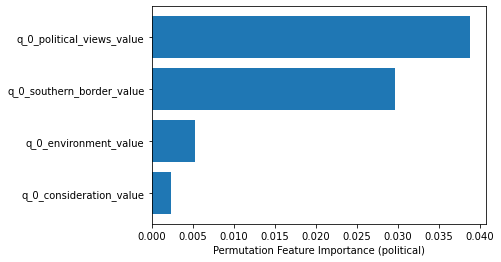

In [35]:
X_test_political = X_test[[
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
]]

model_svr_optimal.fit(X_train_policical, y_train)
y_predict = model_svr_optimal.predict(X_test_political)
rmse_test = sqrt(mean_squared_error(y_test, y_predict))
print("Testing RMSE optimal: %.3f" % rmse_test)

# plot of feature importance
perm_importance = permutation_importance(model_svr_optimal, X_test_political, y_test)
sort_index = perm_importance.importances_mean.argsort()
plt.barh(X_train_policical.columns.astype("string")[sort_index], perm_importance.importances_mean[sort_index])
plt.xlabel("Permutation Feature Importance (political)")

Text(0.5, 0, 'Permutation Feature Importance (all)')

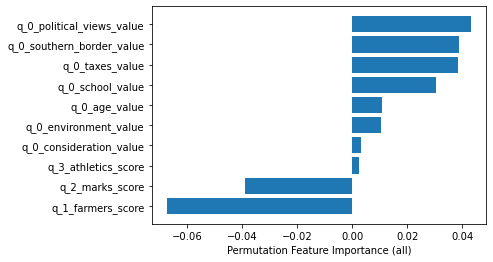

In [29]:
model_svr_optimal.fit(X_train, y_train)
perm_importance = permutation_importance(model_svr_optimal, X_test, y_test)
sort_index = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns.astype("string")[sort_index], perm_importance.importances_mean[sort_index])
plt.xlabel("Permutation Feature Importance (all)")